# Recurrent Neural Network

## 1) Importing the packages and data pre-processing

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

df_training = pd.read_csv('Google_Stock_Price_Train.csv')

df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [26]:
print(df_training.head())
print(df_training.tail())

       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800
            Date    Open    High     Low   Close     Volume
1253  12/23/2016  790.90  792.74  787.28  789.91    623,400
1254  12/27/2016  790.68  797.86  787.66  791.55    789,100
1255  12/28/2016  793.70  794.23  783.20  785.05  1,153,800
1256  12/29/2016  783.33  785.93  778.92  782.79    744,300
1257  12/30/2016  782.75  782.78  770.41  771.82  1,770,000


In [ ]:
df

We have no null values, and the data from january 3rd of 2012, to december 30th of 2016

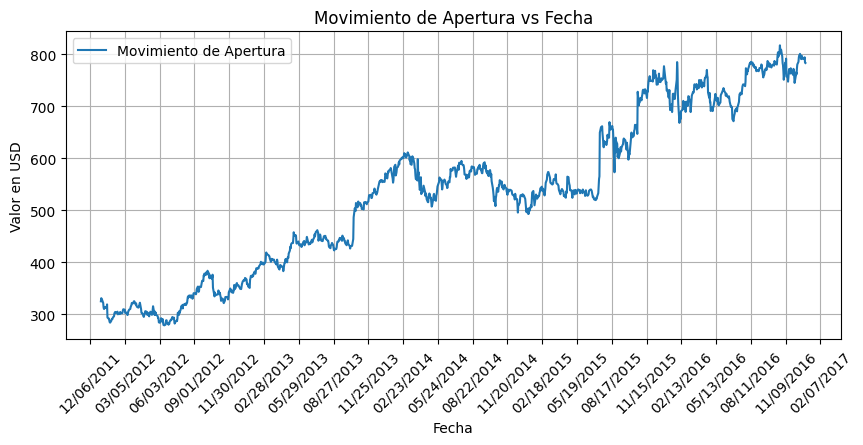

In [14]:
import matplotlib.dates as mdates

ploting_df = df_training.copy()
ploting_df['Date'] = pd.to_datetime(ploting_df['Date'], format = '%m/%d/%Y')

plt.figure(figsize=(10,4))
plt.plot(ploting_df['Date'], ploting_df['Open'], label = 'Movimiento de Apertura')

# Adjust X axis
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=90))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.xticks(rotation = 45)

plt.title('Movimiento de Apertura vs Fecha')
plt.xlabel('Fecha')
plt.ylabel('Valor en USD')
plt.legend()
plt.grid(True)
plt.show()

## 2) Adjust format and keep important information

First, we want to predice the OPEN value, (we could've chose other values but in this case we will go for that one)

In [22]:
train_set = df_training['Open'].to_frame().values

# As always, we need to fit the data with a Scaler. In this case, we are going to use the Min Max Scaler, which performs a Normalization on the data.
# The reason, is that is highly recommended to use this tipe of fitting before using an RNN.

# The values have to be normalized. This is a Normalization since the formula applied is: 

# X_norm = (X_real - min) / (max-min)

# Where "min" is the the minimun value of the X set and max is the max value of the X set.

scaler = MinMaxScaler(feature_range = (0,1)) # The values that are going to come out of the scaler are always between 0 and 1

train_set_scaled = scaler.fit_transform(train_set)

## 3) Fit the data and variables that the model is going to use

We have to define, how many "t" times the model is going to see to the past. Remember that each value P is actualy a function in time
where X(t) = P_t, and the model is going to try to ajust this function X(t) as good as it can.

In this case, we are going to use 3 months in the past (you are actually have to try different values to see which one fits the best).

In [36]:
#We create the lists that are going to form our array
X_train = []
Y_train = []

#Since we are going to use the 90 days in the past to predict the 91st day value, we have to start in the day number 91.

for i in range(90, len(train_set_scaled)):
    X_train.append(train_set_scaled[i-90:i, 0]) # Note that the array that we are adding is a 1D array
    Y_train.append(train_set_scaled[i,0]) #Note that here we use 0 to spicfy  the column as a good practice, since train_set_scaled only has 1 column

# Now we are going to turn the lists into arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)


In [37]:
type(X_train)

list